In [3]:
## Import Python packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sea
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split, GridSearchCV

import random

## Import torch related packages
import torch
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn

## Import packages from the github clone
import dataprep as dpre
import autoencoders as ae
import mlp as mlp

In [4]:
## Setting visualization settings for Seaborn
colors = sea.color_palette('tab10',10)
sea.set_theme(context='paper', style='whitegrid', palette='tab10')

In [5]:
## Set random seed
seed = 100
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [6]:
## Load data into numpy arrays
data_path = './data/'
## Experiment data
expt_arr = np.load(os.path.join(data_path,'mod_expt.npy'))
## Simulated SLDs data
sld_arr = np.load(os.path.join(data_path,'mod_sld_fp49.npy'))
## Chi paramaters of simulated SLDs data
params_arr = np.load(os.path.join(data_path,'mod_params_fp49.npy'))

In [7]:
## Set parameters

## Dimension of the latent space 
latent_dim = 2
dim_list = [('l' + str(i + 1)) for i in range(latent_dim)]
## Parameter size
num_params = params_arr.shape[1]
## Dimension of the input curves
in_d1 = 2
in_d2 = 72
## Number of epochs
ae_epochs = 800
mlp_epochs = 800
## Batch size per epoch
batch_size = 16
## Loss function (does not pass into VAE)
loss_fn = torch.nn.MSELoss()
## Establish processor type
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


In [8]:
## Simulation has some errors, so find flat data
flat_data = []
for i in range(sld_arr.shape[0]):
  y_start = sld_arr[i,1,0]
  if (sld_arr[i,1,1] == y_start and sld_arr[i,1,2] == y_start):
    flat_data.append(i)

## Remove flat data for SLDs, and their corresponding entires in parameter data array
sld_arr_clean = np.delete(sld_arr, flat_data, 0)
params_arr_clean = np.delete(params_arr, flat_data, 0)

sld_arr_clean.shape, params_arr_clean.shape

((5902, 2, 72), (5902, 3))

In [9]:
## Remove non-impact chi1 data points

bad_chi1 = []
for i in range(sld_arr_clean.shape[0]):
  if (params_arr_clean[i,0] <= 0.07 or params_arr_clean[i,0] >= 0.12):
    bad_chi1.append(i)

sld_arr_cut = np.delete(sld_arr_clean, bad_chi1, 0)
params_arr_cut = np.delete(params_arr_clean, bad_chi1, 0)

sld_arr_cut.shape, params_arr_cut.shape

((1931, 2, 72), (1931, 3))

In [10]:
## Find ranges of paramters for normalization

chi1_vals = params_arr_cut[:,0]
chi1_min, chi1_max  = chi1_vals.min(), chi1_vals.max()
print('chi1-range= ', chi1_min, ' to ', chi1_max)

chi2_vals = params_arr_cut[:,1]
chi2_min, chi2_max  = chi2_vals.min(), chi2_vals.max()
print('chi2-range= ', chi2_min, ' to ', chi2_max)

chi3_vals = params_arr_cut[:,2]
chi3_min, chi3_max  = chi3_vals.min(), chi3_vals.max()
print('chi3-range= ', chi3_min, ' to ', chi3_max)

## Norm data [-1,1]
params_arr_cut[:,0] = ((params_arr_cut[:,0] - chi1_min) * 2/(chi1_max - chi1_min)) - 1
params_arr_cut[:,1] = ((params_arr_cut[:,1] - chi2_min) * 2/(chi2_max - chi2_min)) - 1
params_arr_cut[:,2] = ((params_arr_cut[:,2] - chi3_min) * 2/(chi3_max - chi3_min)) - 1

chi1-range=  0.0701  to  0.119
chi2-range=  -0.6  to  0.6
chi3-range=  -0.59951  to  0.59976


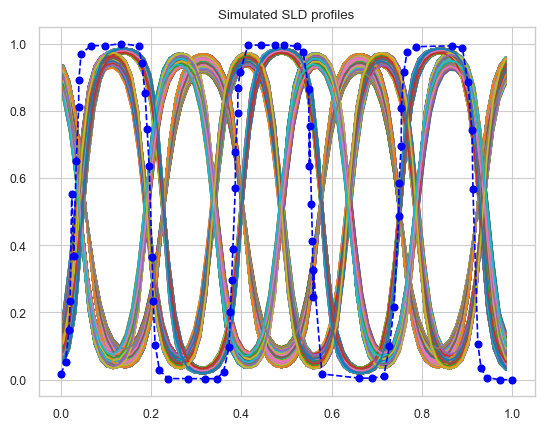

In [11]:
## Show simulated curves vs experiment

for i in range(sld_arr_cut.shape[0]):
  plt.plot(sld_arr_cut[i][0],sld_arr_cut[i][1])
plt.title('Simulated SLD profiles')
plt.plot(expt_arr[0],expt_arr[1],'bo',linestyle='dashed')

In [12]:
## Split data files
list_arrays = dpre.split_arrays(sld_arr_cut, params_arr_cut, size_split = 0.7)

## Convert to tensors
tensor_arrays = [torch.from_numpy(array).float() for array in list_arrays]

## Create dataloaders from tensors
## Training data, validation data, testing data, and dataloaders of each 
tr_data, val_data, tst_data, tr_load, val_load, tst_load = dpre.get_dataloaders(*tensor_arrays, batch_size)

Only use one of the following 2 blocks, top for AE, bottom for a VAE

In [13]:
## Initialize autoencoder, train it, save loss numbers

autoencoder = ae.Autoencoder(144, latent_dim)

ae_train_loss, ae_val_loss = ae.train(autoencoder, tr_load, val_load, ae_epochs, loss_fn)


Epoch: 1, train loss: 0.05883214859401478, valid loss: 0.025943605915496225
Epoch: 2, train loss: 0.011772392110844307, valid loss: 0.0018939702391722484
Epoch: 3, train loss: 0.0014183453475946888, valid loss: 0.0013388860021031608
Epoch: 4, train loss: 0.001177824053379214, valid loss: 0.0012954167997170436
Epoch: 5, train loss: 0.0010362322260762619, valid loss: 0.0010607589348709506
Epoch: 6, train loss: 0.0007631423917379888, valid loss: 0.0007528310004425677
Epoch: 7, train loss: 0.0007117033189655665, valid loss: 0.0007312181895892871
Epoch: 8, train loss: 0.0006762589196167777, valid loss: 0.0006573866443144844
Epoch: 9, train loss: 0.000531418137218091, valid loss: 0.0005252304491525712
Epoch: 10, train loss: 0.00043217191517161315, valid loss: 0.00040571204284022217
Epoch: 11, train loss: 0.00037982407957315445, valid loss: 0.0005111427162773907
Epoch: 12, train loss: 0.00035197464338339426, valid loss: 0.00035545873412813405
Epoch: 13, train loss: 0.0003352487923728083, vali

In [14]:
## Initialize variational autoencoder, train it, save loss numbers
'''
autoencoder = ae.VariationalAutoencoder(144, latent_dim)

ae_train_loss, ae_val_loss = ae.train_vae(autoencoder, tr_load, val_load, ae_epochs, beta = 1)
'''

'\nautoencoder = ae.VariationalAutoencoder(144, latent_dim)\n\nae_train_loss, ae_val_loss = ae.train_vae(autoencoder, tr_load, val_load, ae_epochs, beta = 1)\n'

Text(0.5, 1.0, 'Autoencoder Training')

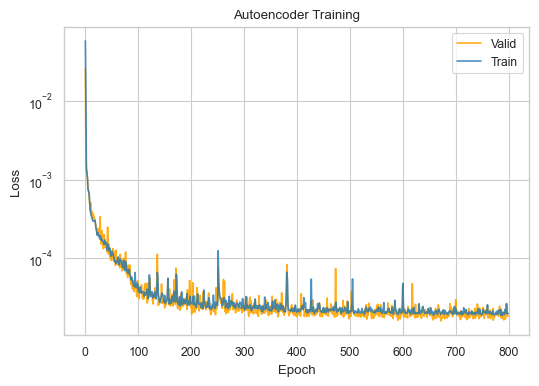

In [15]:
## Chart autoencoder training and validation loss per epoch
plt.figure(figsize=(6,4))
plt.semilogy(ae_val_loss, label='Valid', color = 'orange', alpha=.9)
plt.semilogy(ae_train_loss, label='Train', alpha=0.8)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training')

In [16]:
## Run our training set through the final model, gather latent vectors, and store in a pandas dataframe
encoded_samples = []
for sample in tr_data:
    curve = sample[0].view(sample[0].size(0), -1).flatten().to(device)
    labels = sample[1]
    autoencoder.eval()
    with torch.no_grad():
      latent_vars = autoencoder.encoder(curve).numpy()
    latent_sample = {f"l{i+1}": var for i, var in enumerate(latent_vars)}
    for i in range(num_params):
      label_index = 'chi'+str(i+1)
      latent_sample[label_index] = labels[i].item()
    encoded_samples.append(latent_sample)
df_encoded_samples = pd.DataFrame(encoded_samples)

Text(0, 0.5, '$\\ell_{2}$')

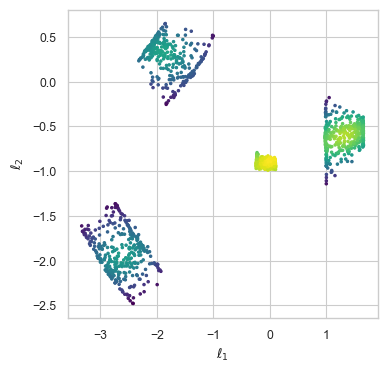

In [17]:
## Plotting the joint distributions for the latent variables for the simulated sld curves
## Only plots in 2 dimensions, so any latent space of dimension 3 or higher will need to be varied here
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1,1,1)
x = df_encoded_samples['l1']
y = df_encoded_samples['l2']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
sc=ax.scatter(x, y, c=z, s=3, cmap='viridis')
ax.set_xlabel('$\ell_{1}$')
ax.set_ylabel('$\ell_{2}$')

In [18]:
## Method to take a trained model and dataloader, and output 4 arrays as pytorch tensors:
## Input curves, output curves, latent space vectors, and chi parameters
def get_full_output(ae_model, dataloader):
    list_curves = []
    list_recon = []
    list_latent = []
    list_labels = []

    for curve, labels in dataloader:
        
        ae_model.eval()
        with torch.no_grad():
            latent_vars = ae_model.encoder(curve.view(curve.size(0), -1))
            recon_curve = ae_model.decoder(latent_vars)

        list_curves.append(curve)
        list_labels.append(labels)
        list_latent.append(latent_vars)
        list_recon.append(recon_curve)
    
    return [torch.cat(list_curves), torch.cat(list_recon), torch.cat(list_latent), torch.cat(list_labels)]

In [19]:
## Run above method for our training, validation, and testing datasets
full_data_train = get_full_output(autoencoder, tr_load)
full_data_valid = get_full_output(autoencoder, val_load)
full_data_test = get_full_output(autoencoder, tst_load)

mlp_input_data = [full_data_train[2], full_data_train[3], full_data_valid[2], full_data_valid[3], full_data_test[2], full_data_test[3]]

In [20]:
## Create MLP training sets, establish batch size for MLP model
mlp_tr_data, mlp_val_data, mlp_tst_data, mlp_tr_load, mlp_val_load, mlp_tst_load = dpre.get_dataloaders(*mlp_input_data, batch_size)

In [21]:
## Initialize MLP model, train it, store loss values
percep = mlp.deep_MLP(latent_dim, num_params)

train_loss, val_loss = mlp.train(percep, mlp_tr_load, mlp_val_load, mlp_epochs, loss_fn)

Epoch: 1, train loss: 0.2681858001386418, valid loss: 0.20819392094486638
Epoch: 2, train loss: 0.17203471967402625, valid loss: 0.16523535784922147
Epoch: 3, train loss: 0.15227884755415075, valid loss: 0.1526398952854307
Epoch: 4, train loss: 0.13674541185883915, valid loss: 0.1325135352580171
Epoch: 5, train loss: 0.11658801642410896, valid loss: 0.11216095482048236
Epoch: 6, train loss: 0.09589942180935074, valid loss: 0.094244993830982
Epoch: 7, train loss: 0.08001274299972197, valid loss: 0.07177808606310894
Epoch: 8, train loss: 0.06523153497015728, valid loss: 0.06430972445952265
Epoch: 9, train loss: 0.056826047730796476, valid loss: 0.05731301872353805
Epoch: 10, train loss: 0.05133857321651543, valid loss: 0.05198212516935248
Epoch: 11, train loss: 0.046798225799027614, valid loss: 0.04581925596453642
Epoch: 12, train loss: 0.0449591565219795, valid loss: 0.044345793559363016
Epoch: 13, train loss: 0.04228139861541636, valid loss: 0.04156965791786972
Epoch: 14, train loss: 0

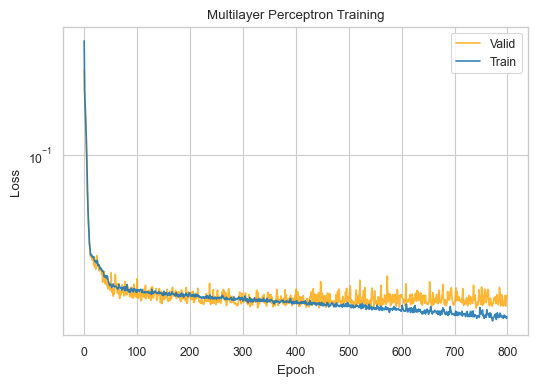

In [22]:
## Plot losses for MLP
plt.figure(figsize=(6,4))
plt.semilogy(val_loss, label='Valid', color = 'orange', alpha=0.8)
plt.semilogy(train_loss, label='Train', alpha=.9)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multilayer Perceptron Training')
plt.legend()

In [23]:
## Run our testing set through the MLP, store in a pandas dataframe
test_samples = []
for sample in mlp_tst_data:
    img = sample[0]
    img = img.view(img.size(0), -1).flatten().to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    percep.eval()
    with torch.no_grad():
        test_label  = percep(img)
    test_label = test_label.cpu().numpy()
    # print(enumerate(encoded_img))
    test_sample = {f"pred_chi{i+1}": enc for i, enc in enumerate(test_label)}
    for i in range(num_params):
      label_index = 'chi'+str(i + 1)
      test_sample[label_index] = float(label_val[i])
    test_samples.append(test_sample)
df_test_samples = pd.DataFrame(test_samples)
df_test_samples

,pred_chi1,pred_chi2,pred_chi3,chi1,chi2,chi3
0,-0.060586,0.672016,-0.480132,-0.026585,0.321667,-0.090130
1,-0.869825,0.396283,0.678548,-0.799591,0.413333,0.741660
2,0.879251,-0.627288,0.392971,0.918200,-0.378333,0.384075
3,0.242073,0.709903,0.512543,0.304703,0.876667,0.592302
4,0.725216,-0.607056,-0.328758,0.672802,-0.715000,-0.440693
...,...,...,...,...,...,...
285,0.691472,-0.663621,-0.263318,0.959100,-0.946667,-0.629375
286,0.767128,0.678482,0.698754,0.713701,0.510000,0.570605
287,-0.892447,-0.365808,-0.902051,-0.775051,-0.491667,-0.922103
288,-0.626118,0.001054,-0.684852,-0.484663,-0.010250,-0.903841


In [24]:
## Un-norm data
df_test_samples.iloc[:,0] = (((df_test_samples.iloc[:,0] + 1) * (chi1_max - chi1_min)) / 2) + chi1_min
df_test_samples.iloc[:,1] = (((df_test_samples.iloc[:,1] + 1) * (chi2_max - chi2_min)) / 2) + chi2_min
df_test_samples.iloc[:,2] = (((df_test_samples.iloc[:,2] + 1) * (chi3_max - chi3_min)) / 2) + chi3_min

df_test_samples.iloc[:,3] = (((df_test_samples.iloc[:,3] + 1) * (chi1_max - chi1_min)) / 2) + chi1_min
df_test_samples.iloc[:,4] = (((df_test_samples.iloc[:,4] + 1) * (chi2_max - chi2_min)) / 2) + chi2_min
df_test_samples.iloc[:,5] = (((df_test_samples.iloc[:,5] + 1) * (chi3_max - chi3_min)) / 2) + chi3_min

In [25]:
## Calculate error in our chi predictions
df_test_samples['chi1_err'] = (abs((df_test_samples['pred_chi1'] - df_test_samples['chi1']) / df_test_samples['chi1'])) * 100
df_test_samples['chi2_err'] = (abs((df_test_samples['pred_chi2'] - df_test_samples['chi2']) / df_test_samples['chi2'])) * 100
df_test_samples['chi3_err'] = (abs((df_test_samples['pred_chi3'] - df_test_samples['chi3']) / df_test_samples['chi3'])) * 100

## Store mean error of each chi parameter
df_l2_err = pd.DataFrame()
df_l2_err['chi1_err'] = [df_test_samples['chi1_err'].mean()]
df_l2_err['chi2_err'] = [df_test_samples['chi2_err'].mean()]
df_l2_err['chi3_err'] = [df_test_samples['chi3_err'].mean()]
df_l2_err

,chi1_err,chi2_err,chi3_err
0,2.207805,72.061291,174.171591


Text(0.5, 0, 'True')

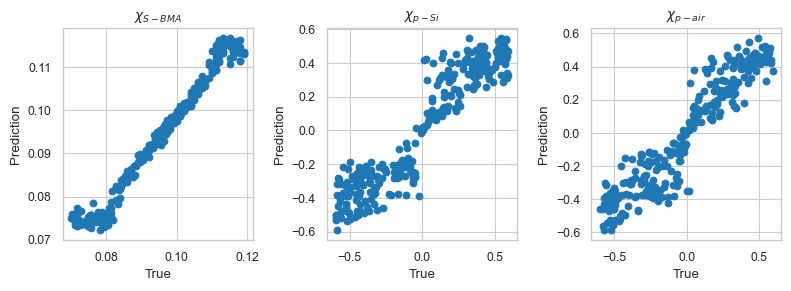

In [26]:
## Create plot of true vs model-predicted chi parameter values

fig, fits = plt.subplots(1, 3, sharey=False, tight_layout=True, dpi=100, figsize=(8, 3))

## Chi 1 chart
l0 = plt.subplot(1, 3, 1)
l0.scatter(df_test_samples.loc[:,'chi1'],df_test_samples.loc[:,'pred_chi1'])
plt.ylabel('Prediction')
l0.set_title('$\chi_{S-BMA}$')
plt.xlabel('True')

## Chi 2 chart
l1 = plt.subplot(1, 3, 2)
l1.scatter(df_test_samples.loc[:,'chi2'],df_test_samples.loc[:,'pred_chi2'])
plt.ylabel('Prediction')
l1.set_title('$\chi_{p-Si}$')
plt.xlabel('True')

## Chi 3 chart
l2 = plt.subplot(1, 3, 3)
l2.scatter(df_test_samples.loc[:,'chi3'],df_test_samples.loc[:,'pred_chi3'])
plt.ylabel('Prediction')
l2.set_title('$\chi_{p-air}$')
plt.xlabel('True')

,l1,l2,chi1,chi2,chi3
0,-3.464742,-0.825013,1.132971,-0.012952,-1.026334


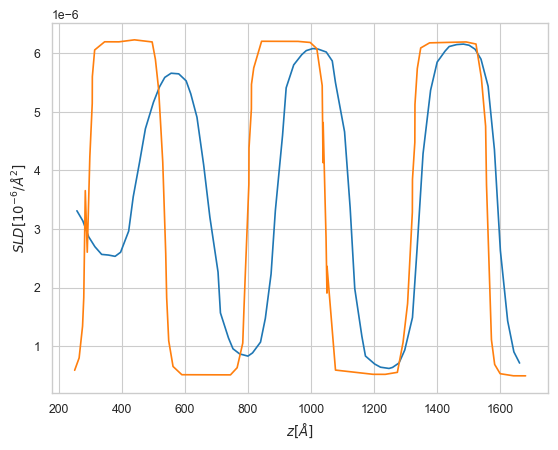

In [27]:
## Interpolate experiment curve vs SLD (fixed) x values
int_expt = np.interp(sld_arr[0][0], expt_arr[0], expt_arr[1])
#expt_arr_n = np.asarray([[sld_arr[0][0], int_expt]])
expt_arr_n = np.asarray([[expt_arr[0], expt_arr[1]]])

## Turn experiment curve into torch tensor
expt_labels = []
expt_curve = torch.from_numpy(expt_arr_n[0]).flatten().float()
expt_curve = expt_curve.to(device)

autoencoder.eval()
percep.eval()

## Run experiment curve through models
with torch.no_grad():
  encoded_expt = autoencoder.encoder(expt_curve)
  decoded_expt = autoencoder.decoder(encoded_expt)
  out_label  = percep(encoded_expt)

## Store latent vectors and MLP data in numpy arrays
encoded_expt = encoded_expt.numpy()
out_label = out_label.numpy()
expt_label = {f"l{i+1}": enc for i, enc in enumerate(encoded_expt)}

## Label 
for i in range(num_params):
    label_index = 'chi' + str(i+1)
    expt_label[label_index] = out_label[i]

## Rescale our SLD curve back to it's original size
## These numbers are gathered from the file in which the SLDs were originally scaled down
xscaled_decode = (decoded_expt.reshape(in_d1,in_d2).numpy()[0] * (1681.68 - 250.17)) + 250.17
yscaled_decode = (decoded_expt.reshape(in_d1,in_d2).numpy()[1] * (6.232376332701351e-06 - 4.912958904784194e-07)) + 4.912958904784194e-07

xscaled_input = (expt_curve.reshape(in_d1,in_d2).numpy()[0] * (1681.68 - 250.17)) + 250.17
yscaled_input = (expt_curve.reshape(in_d1,in_d2).numpy()[1] * (6.232376332701351e-06 - 4.912958904784194e-07)) + 4.912958904784194e-07


## Plot model output vs experiment input
plt.plot(xscaled_decode,yscaled_decode) 
plt.plot(xscaled_input,yscaled_input)
plt.xlabel('$z[\AA]$')
plt.ylabel('$SLD[10^{-6}/\AA^2]$')

## Display latent space vectors
expt_labels.append(expt_label)
df_expt_labels = pd.DataFrame(expt_labels)
df_expt_labels

Text(0, 0.5, '$\\ell_{2}$')

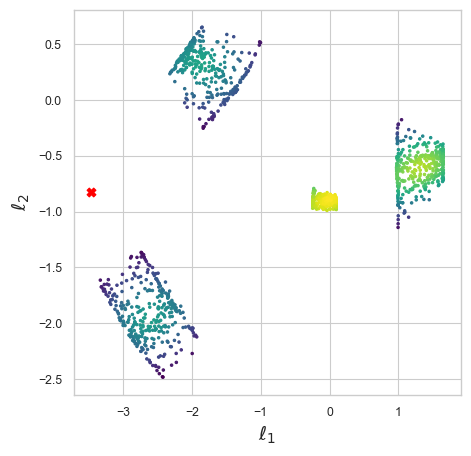

In [28]:
## Plotting the latent space with our experimental data represented as well
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
x = df_encoded_samples['l1']
y = df_encoded_samples['l2']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
sc=ax.scatter(x, y, c=z, s=3, cmap='viridis')
ax.scatter(df_expt_labels['l1'],df_expt_labels['l2'],marker='X', color='red', s = 40)
ax.set_xlabel('$\ell_{1}$', fontsize = 14)
ax.set_ylabel('$\ell_{2}$', fontsize = 14)